# Upstream regulation network reconstruction, with synonym expansion, and network unification (based on standard names)

The following code defines the main parameter and data considered as input: 
- SPARQL_ENDPOINT : the main PathwayCommons (PC) SPARQL endpoint 
- CHUNKS_SIZE : the number of genes to be processed within each PC query
- MAX_DEPTH : the maximum depth of exploration, can be null to explore the full regulation graph
- DATA_SOURCES : used to limit the data source to be explored. Must be a list of values from : bind, biogrid, corum, ctd, dip, drugbank, hprd, humancyc, inoh, intact, kegg, mirtarbase, netpath, panther, pid, psp, reactome, reconx, smpdb, wp, intact_complex, msigdb. 

In [1]:
from typing import List, Any

from IPython.display import display, Markdown, Latex
from rdflib import Graph, RDF, RDFS, Namespace
from SPARQLWrapper import SPARQLWrapper, JSON
from string import Template

import networkx as nx
import matplotlib.pyplot as plt
#from nxpd import draw

import requests
import json
import io
import time
import csv

#INPUT_GENES = ['JUN/FOS', 'SCN5A']
INPUT_GENES = ['COL1A1']
#INPUT_GENES = ['SCN5A', 'HEY2']

SPARQL_ENDPOINT = "http://rdf.pathwaycommons.org/sparql"  # type: str
CHUNKS_SIZE = 40  # type: int
MAX_DEPTH = 5 # type: int
SKIP_SMALL_MOLECULES = True # type: Boolean
#DATA_SOURCES = ['pid', 'humancyc', 'panther', 'msigdb']
DATA_SOURCES = []  # type: List[str]

HAS_MAX_DEPTH = False
try:
  MAX_DEPTH
except NameError:
  HAS_MAX_DEPTH = False
else:
  HAS_MAX_DEPTH = True

HAS_DATA_SOURCES = False
try:
  DATA_SOURCES
except NameError:
  HAS_DATA_SOURCES = False
else:
  HAS_DATA_SOURCES = True

In [2]:
#def init_gene_synonyms_cache():
#    cache = []
#    with open('Homo_sapiens.gene_info', newline='') as csvfile:
#        reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
#        for row in reader:
#            entry = {'key':row[2], 'synonym':row[4].split('|')}
#            cache.append(entry)
#    return cache

def init_gene_synonyms_cache():
    index_syn = {}
    index_std = {}
    with open('Homo_sapiens.gene_info', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
        for row in reader:
            index_std[row[2]] = row[4].split('|')
            
            index_syn[row[2]] = row[2]
            for syn in row[4].split('|'):
                index_syn[syn] = row[2]
    return index_std, index_syn

#cache = init_gene_synonyms_cache()

#print('--- Memory foot print cache v1 ---')
#s = 0
#for e in cache:
#    s += 1 + len(e['synonym'])
#print('Cache size : '+str(s))

print('--- Memory foot print cache ---')
index_std, index_syn = init_gene_synonyms_cache()
print('index_syn size : ' + str(len(index_syn.keys()) * 2))
s = 0
for key, value in index_std.items():
    s += 1 + len(value)
print('index_std size : ' + str(s))

--- Memory foot print cache ---
index_syn size : 244398
index_std size : 161611


In [3]:
def fast_get_std_name(n, index_syn):
    return index_syn[n]

def fast_get_synonyms(n, index_std, index_syn):
    try:
        std = index_syn[n]
    except:
        std = None
    try:
        synonyms = index_std[std]
    except:
        synonyms = []
    
    all_names = []
    if std != None:    
        all_names = [std] + synonyms
    else:
        all_names = synonyms
    if n in all_names:
        all_names.remove(n) 
    return all_names

def fast_are_synonyms(n, m, index_syn):
    try:
        index_syn[n]
    except:
        return False
    try:
        index_syn[m]
    except:
        return False
    return (index_syn[n] == index_syn[m])

start = time.time()
print('ABG has for synonyms: ' + str(fast_get_synonyms('ABG', index_std=index_std, index_syn=index_syn)))
print('ABG has for standard name: ' + str(fast_get_std_name('ABG', index_syn=index_syn)))
elapsed = time.time() - start
print('Time = ' + str(elapsed))
print('A has for synonyms: ' + str(fast_get_synonyms('A', index_std=index_std, index_syn=index_syn)))

ABG has for synonyms: ['A1BG', 'A1B', 'GAB', 'HYST2477']
ABG has for standard name: A1BG
Time = 0.0003859996795654297
A has for synonyms: []


In [4]:
def expandGeneNames(toBeExplored):
    expansion_suffixes = [' mRna', ' protein']
    new_names = []
    for gene in toBeExplored:
        for suf in expansion_suffixes:
            new_names.append(str(gene+suf))
    return (toBeExplored+new_names)

def removeSuffixForUnification(name):
    expansion_suffixes = [' mRna', ' protein', ' mRNA', ' mutant form', ' complex', ' modified form']
    for suf in expansion_suffixes:
        if suf in name:
            print('\t\t! removing suffix '+str(suf)+' for '+str(name))
            name = name.replace(suf, '')
    return name

#print(INPUT_GENES)
#print()
#print(expandGeneNames(INPUT_GENES))
#print(removeSuffixForUnification('SCN5A mRna'))
#print(removeSuffixForUnification('SCN5A protein'))
#print(removeSuffixForUnification('SCN5A mRna protein'))
#print(removeSuffixForUnification('SCN5A'))

# 1. Pathway Commons template SPARQL query
The query will be post-processed to integrate filters on gene names `$filter_Chunks`, for skipping small molecules `$filter_SkipSmallMollecules`, and considering only a subset of data sources `$filter_DataSources`. 

In [5]:
tpl_select_reg_query = """
PREFIX bp: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?controllerName ?controlType ?controlledName ?ds WHERE {
    $filter_Chunks
    $filter_SkipSmallMollecules
    $filter_DataSources
    
    {?participant bp:displayName ?controlledName .} UNION
    {?participant bp:name ?controlledName .}
    ?participant rdf:type ?controlledType . 
        
    {?controller bp:displayName ?controllerName .} UNION
    {?controller bp:name ?controllerName .}
    ?controller rdf:type ?controllerType . 
    
    ?controlled bp:participant ?participant .

    ?tempReac a bp:TemplateReactionRegulation ; 
        bp:controlled ?controlled ; 
        bp:controller ?controller ; 
        bp:controlType ?controlType ; 
        bp:dataSource ?source . 
} 
"""

The query is based on the BioPax ontology. It aims at matching a graph pattern on the full Pathway Commons knowledge base. The following diagram shows variable graph nodes (dashed circles), fixed nodes (rectangle), and what we search for in red. 

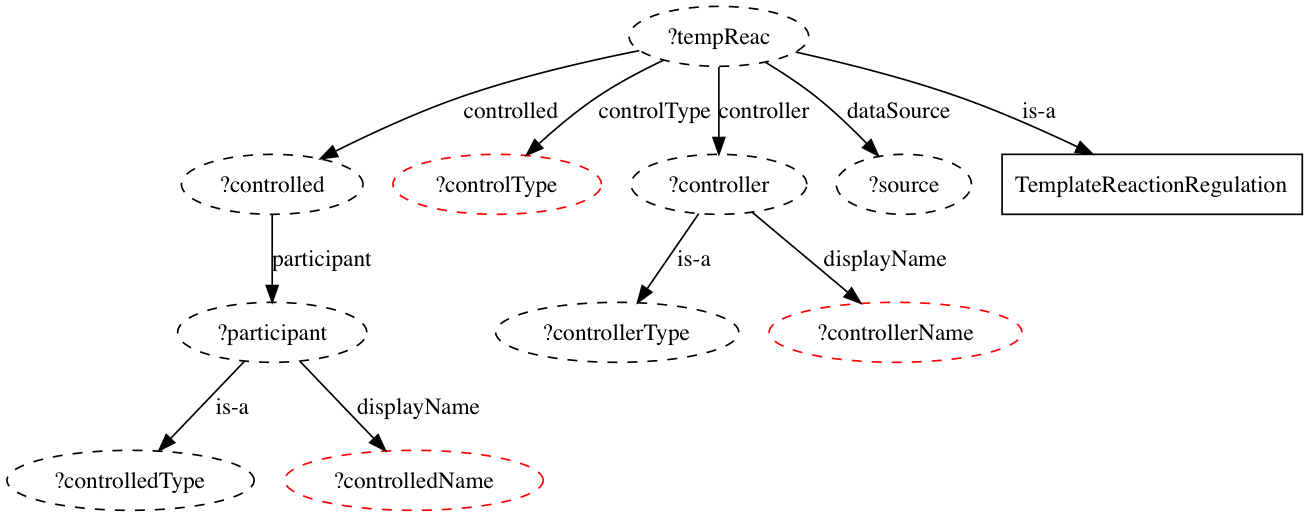

In [6]:
from nxpd import draw
bgp = nx.DiGraph()
bgp.graph['dpi'] = 120

bgp.add_node("?controllerName", color="red")
bgp.add_node("?controlType", color="red")
bgp.add_node("?controlledName", color="red")

bgp.add_edge("?participant", "?controlledName", label="displayName")
bgp.add_edge("?participant", "?controlledType", label="is-a")
bgp.add_edge("?controller", "?controllerName", label="displayName")
bgp.add_edge("?controller", "?controllerType", label="is-a")
bgp.add_edge("?controlled", "?participant", label="participant")
bgp.add_edge("?tempReac", "TemplateReactionRegulation", label="is-a")
bgp.add_edge("?tempReac", "?controlled", label="controlled")
bgp.add_edge("?tempReac", "?controller", label="controller")
bgp.add_edge("?tempReac", "?controlType", label="controlType")
bgp.add_edge("?tempReac", "?source", label="dataSource")
for e in bgp.edges():
    for i in range(0,2):
        if "?" in e[i]:
            bgp.add_node(e[i], style='dashed')
        else: 
            bgp.add_node(e[i], shape='rectangle')
    
draw(bgp, show='ipynb')

### Splitting a list of genes based on `CHUNKS_SIZE`

In [7]:
def gen_chunks(list_of_genes):
    """
    """
    chunks_list = []
    chunk = []
    cpt = 0
    for gene in list_of_genes:
        chunk.append(gene)
        cpt += 1
        if ((cpt % CHUNKS_SIZE) == 0):
            chunks_list.append(chunk)
            chunk = []
    if (len(chunk) > 0):
        chunks_list.append(chunk)
    return chunks_list

### Generation of a SPARQL Filter clause to restrict data sources
Produces something like
```
FILTER (?source IN (<http://pathwaycommons.org/pc2/pid>, <http://pathwaycommons.org/pc2/humancyc>))
```

In [8]:
def gen_data_source_filter(data_sources):
    """
    generates a SPARQL Filter clause aimed at 
    limiting the possible values of a ?source vairable
    """
    filter_clause = ''
    if len(data_sources) > 0 : 
        filter_clause = 'FILTER (?source IN ('
        for ds in data_sources :
            dsUri = '<http://pathwaycommons.org/pc2/' + ds.lower() + '>'
            filter_clause = filter_clause + dsUri + ', '
        k = filter_clause.rfind(", ")
        filter_clause = filter_clause[:k]
        filter_clause = filter_clause + ')) .'
    return filter_clause

### Generation of a SPARQL Filter clause to restrict gene/protein/etc. names
Produces something like
```
FILTER (
    ((?controlledName = "JUN"^^xsd:string) && (?controllerName != "JUN"^^xsd:string))
    || ((?controlledName = "FOS"^^xsd:string) && (?controllerName != "FOS"^^xsd:string))
```

In [9]:
def gen_chunks_filter(chunks):
    """
    """
    filter_clause = ''
    if len(chunks) > 0 : 
        filter_clause = 'FILTER ( \n'
        for g in chunks :
            filter_clause += '((?controlledName = "' + g + '"^^xsd:string) && (?controllerName != "' + g + '"^^xsd:string)) \n'
            filter_clause +=' || '
        k = filter_clause.rfind(" || ")
        filter_clause = filter_clause[:k]
        filter_clause += ' ) .'
    return filter_clause

### OPTIMIZATION : FILTER -> VALUES

In [10]:
def gen_chunks_values_constraint(chunks):
    """
    Generation of a SPARQL VALUES clause to restrict gene/protein/etc. names
    Produces something like
        VALUES ?controlledName {"hsa-miR-6079"^^xsd:string "hsa-miR-4452"^^xsd:string "hsa-miR-6512-5p"^^xsd:string "RBPJ"^^xsd:string "NICD"^^xsd:string}
    """
    filter_clause = ''
    if len(chunks) > 0 :
        filter_clause = 'VALUES ?controlledName { \n'
        for g in chunks :
            filter_clause += '"' + g + '"^^xsd:string '
        k = filter_clause.rfind(" ")
        filter_clause = filter_clause[:k]
        filter_clause += ' } .'
    return filter_clause

### Generation of a SPARQL Filter clause to exclude small molecules
Produces something like
```
FILTER( str(?controllerType) != "http://www.biopax.org/release/biopax-level3.owl#SmallMolecule")
```

In [11]:
def gen_small_mol_filter(skip_small_molecules = True):
    if skip_small_molecules:
        return 'FILTER( str(?controllerType) != "http://www.biopax.org/release/biopax-level3.owl#SmallMolecule")  .'
    else:
        return ''

# 2. Upstream regulation algorithm
Recursive exploration with two stopping criteria: 
- nothing new to explore
- the maximum exploration depth is reached

In [12]:
def upstream_regulation(to_be_explored, already_explored, sif_network, depth, explored_reg):
    """
    """
    
    """ 1st stopping criteria """
    if len(to_be_explored) == 0:
        print("Exploring done")
        return sif_network
    
    """ 2nd stopping criteria """
    if (HAS_MAX_DEPTH and (depth >= MAX_DEPTH)):
        print("Exploring alted due to maximum depth")
        return sif_network
    
    print()
    print('exploration depth ' + str(depth))
    print('to be explored ' + str(to_be_explored))
    
    """"""
    """ Decomposing protein complexes """
    """"""
    new_to_be_explored = []
    for name in to_be_explored:
        splits = name.split('/')
        if len(splits) > 1 : 
            print(name + ' decomposed into ' + str(splits))
            new_to_be_explored.extend(splits)
            for s in splits:
                sif_network.append({"source":s, "relation":"PART_OF", "target":name})
    
    for new in new_to_be_explored:
        if new not in to_be_explored:
                to_be_explored.append(new)
    print('to be explored after complex decomposition ' + str(to_be_explored))
    
    """"""
    """ Expanding the list with synonyms """
    """"""
    new_to_be_explored = []
    for name in to_be_explored:
        synonyms = fast_get_synonyms(name, index_std=index_std, index_syn=index_syn)
        for s in synonyms:
            if s not in "-":
                new_to_be_explored.append(s)
    if len(new_to_be_explored) > 0:
        print('new synonmys to be explored:' + str(new_to_be_explored))
    for new in new_to_be_explored:
        if new not in to_be_explored:
                to_be_explored.append(new)

    """"""
    """ Expanding the list with [' mRna', ' protein'] """
    """"""
    new_to_be_explored = expandGeneNames(to_be_explored)   
    for new in new_to_be_explored:
        if new not in to_be_explored:
                to_be_explored.append(new)
    
    """"""
    """ Grouping genes into chunks to be processed remotely by block """
    """"""
    chunks = gen_chunks(to_be_explored)
    to_be_explored = []
    
    """"""
    """ Network reconstruction """
    """"""
    for regulators in chunks :
        print('exploring ' + str(regulators))
        query = Template(tpl_select_reg_query)
        
        fds = gen_data_source_filter(DATA_SOURCES)
        #fchunks = gen_chunks_filter(regulators)
        fchunks = gen_chunks_values_constraint(regulators)
        ssm = gen_small_mol_filter(SKIP_SMALL_MOLECULES)
        
        q = query.substitute(filter_DataSources = fds,
                    filter_SkipSmallMollecules = ssm, 
                    filter_Chunks = fchunks)
        
#        print("=====================")
#        print(q)
#        print("=====================")
        
        sparql = SPARQLWrapper(SPARQL_ENDPOINT)
        sparql.setQuery(q)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        
        already_explored.extend(regulators)
        #print('already explored ' + str(already_explored))
        
        for result in results["results"]["bindings"]:
            source, reg_type, target = result["controllerName"]["value"], result["controlType"]["value"], result["controlledName"]["value"]
            sif_network.append({"source":source, "relation":reg_type, "target":target})
            #print(source + ' --- ' + reg_type + ' --> ' + target)
            
            source = removeSuffixForUnification(source)
            target = removeSuffixForUnification(target)
            
            if source not in already_explored:
                if source not in to_be_explored:
                    to_be_explored.append(source)
                    explored_reg += 1
                    #print('Adding ' + source + ', in to_be_explored')
            #else:
                #print('skipping ' + source + ', already_explored')
        
        print()
        print('Explored ' + str(explored_reg)+ ' regulators')
        
    depth += 1
    upstream_regulation(to_be_explored, already_explored, sif_network, depth, explored_reg)
    
    return sif_network

# 3. RUNNING the algorithm
based on the `INPUT_GENES` list. 

In [13]:
start_time = time.time()

reconstructed_network = upstream_regulation(INPUT_GENES, [], [], depth=0, explored_reg=0)

elapsed_time = round((time.time() - start_time), 2)
print("--- Upstream regulation network in %s seconds ---" % elapsed_time)

G = nx.DiGraph()
for e in reconstructed_network:
#    print(e['source'] + ' --- ' + e['regulation'] + ' --> ' + e['target'])
    G.add_edge(e['source'], e['target'], 
               color = 'g' if (e['relation'] in 'ACTIVATION') else 'r',
               label=e['relation'])

print('Number of nodes = ' + str(len(G.nodes())))
print('Number of edges = ' + str(len(G.edges())))


exploration depth 0
to be explored ['COL1A1']
to be explored after complex decomposition ['COL1A1']
new synonmys to be explored:['EDSARTH1', 'EDSC', 'OI1', 'OI2', 'OI3', 'OI4']
exploring ['COL1A1', 'EDSARTH1', 'EDSC', 'OI1', 'OI2', 'OI3', 'OI4', 'COL1A1 mRna', 'COL1A1 protein', 'EDSARTH1 mRna', 'EDSARTH1 protein', 'EDSC mRna', 'EDSC protein', 'OI1 mRna', 'OI1 protein', 'OI2 mRna', 'OI2 protein', 'OI3 mRna', 'OI3 protein', 'OI4 mRna', 'OI4 protein']

Explored 99 regulators

exploration depth 1
to be explored ['hsa-miR-143-3p', 'hsa-miR-29b-3p', 'hsa-miR-29c-3p', 'GTF3A', 'hsa-miR-7162-5p', 'hsa-miR-412-3p', 'STAT6 (dimer)', 'hsa-miR-4776-5p', 'hsa-miR-4800-5p', 'hsa-miR-3619-3p', 'hsa-miR-516b-3p', 'hsa-miR-516a-3p', 'hsa-miR-133a-3p', 'hsa-miR-124-3p', 'hsa-miR-4533', 'hsa-miR-4644', 'hsa-miR-4736', 'hsa-miR-5196-5p', 'hsa-miR-548ah-5p', 'hsa-miR-1249-5p', 'hsa-miR-1253', 'hsa-miR-3122', 'hsa-miR-6745', 'hsa-miR-6747-5p', 'hsa-miR-6752-5p', 'hsa-miR-6758-5p', 'hsa-miR-6880-5p', 'hsa-m


Explored 99 regulators
exploring ['hsa-miR-6847-5p protein', 'hsa-miR-6856-5p mRna', 'hsa-miR-6856-5p protein', 'hsa-miR-6893-5p mRna', 'hsa-miR-6893-5p protein', 'hsa-miR-6894-5p mRna', 'hsa-miR-6894-5p protein', 'hsa-miR-7106-5p mRna', 'hsa-miR-7106-5p protein', 'hsa-miR-7110-5p mRna', 'hsa-miR-7110-5p protein', 'hsa-miR-4741 mRna', 'hsa-miR-4741 protein', 'hsa-miR-4747-5p mRna', 'hsa-miR-4747-5p protein', 'hsa-miR-4779 mRna', 'hsa-miR-4779 protein', 'hsa-miR-6797-5p mRna', 'hsa-miR-6797-5p protein', 'hsa-miR-6804-5p mRna', 'hsa-miR-6804-5p protein', 'hsa-miR-6808-5p mRna', 'hsa-miR-6808-5p protein', 'hsa-miR-6814-5p mRna', 'hsa-miR-6814-5p protein', 'hsa-miR-6825-5p mRna', 'hsa-miR-6825-5p protein', 'hsa-miR-1827 mRna', 'hsa-miR-1827 protein', 'hsa-miR-3150b-3p mRna', 'hsa-miR-3150b-3p protein', 'hsa-miR-3605-5p mRna', 'hsa-miR-3605-5p protein', 'hsa-miR-3609 mRna', 'hsa-miR-3609 protein', 'hsa-miR-4784 mRna', 'hsa-miR-4784 protein', 'hsa-miR-4786-3p mRna', 'hsa-miR-4786-3p protein

In [ ]:
def read_input_genes(filename):
    res = []
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for row in reader:
            res.append(''.join(row))
    return res

input_genes = read_input_genes('/Users/gaignard-a/Documents/Dev/BRAvo/nathalie-TF.csv')

In [ ]:
def write_to_SIF(graph, filename):
    with open(filename, 'w', newline='') as csvfile:
        sif_writer = csv.writer(csvfile, delimiter='\t')
        for e in G.edges(data='label'):
            sif_writer.writerow([e[0], e[2], e[1]])
    print('SIF network written to ' + filename)

write_to_SIF(G, 'out.sif')


In [ ]:
import operator
centrality = nx.degree_centrality(G)
#centrality = nx.closeness_centrality(G)
#centrality = nx.betweenness_centrality(G)
sorted_centrality = reversed(sorted(centrality.items(), key=operator.itemgetter(1)))
sorted_centrality = list(sorted_centrality)
cpt = 0
md = """
| Gene | Degree Centrality |
|------|------|
"""
for g in sorted_centrality:
    md += "| " + g[0] + " | " + str(g[1]) + " | \n"
    cpt += 1
    if cpt > 9:
        break
#print(md)
display(Markdown(md))

In [ ]:
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]

nx.draw_spring(G, 
               with_labels=True, 
               edge_color = colors,
               node_color = 'bisque',
               font_weight='light', 
               node_size = 2000, 
               width = 2)
plt.show()

# 4. Synonym-based network simplification

In [ ]:
def fast_reg_network_syn_simp(graph, index_syn):
    H = graph.copy()
    cpt = 0
    nodes_size = len(H.nodes())
    for n in H.nodes():    
        #print('for each ' + str(n))
        for m in H.nodes():
            if n not in m:
                #print('\tfor each ' + str(m))
                if (fast_are_synonyms(n,m, index_syn=index_syn)):
                    key = index_syn[n]
                    if n not in key:
                        #print('\t\t' + str(n) + ' is synonym with ' + str(m))
                        print('\t\t' + 'merging node ' + str(n) + ' into node ' + str(key))
                        try:
                            H = nx.contracted_nodes(H, key, n)
                        except:
                            continue
                    if m not in key:
                        print('\t\t' + 'merging node ' + str(m) + ' into node ' + str(key))
                        try:
                            H = nx.contracted_nodes(H, key, m)
                        except:
                            continue
    return H

In [ ]:
start_time = time.time()
G_prime = fast_reg_network_syn_simp(G, index_syn)
elapsed_time = round((time.time() - start_time), 2)
print("--- Network simplification in %s seconds ---" % elapsed_time)

write_to_SIF(G_prime, 'out_second.sif')
print('Nodes after simplification = ' + str(len(G_prime.nodes())))
print('Edges after simplification = ' + str(len(G_prime.edges())))

In [ ]:
edges = G_prime.edges()
colors = [G_prime[u][v]['color'] for u,v in edges]

nx.draw_spring(G_prime, 
               with_labels=True, 
               edge_color = colors,
               node_color = 'bisque',
               font_weight='light', 
               node_size = 2000, 
               width = 2)
plt.show()